# Logistic Regression Assumptions

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import math
from sklearn.linear_model import LogisticRegression
from scipy import stats

import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load cleaned data
listings_df = pd.read_csv(os.path.join('data', 'yvr_listing_data_cleaned.csv'))

In [3]:
## Assumption 1 — Linearity of independent variables and log-odds
# This assumption means that relationships between the continuous predictors and the logit (log odds) is linear.
# So the continuous variable should be filtered mannually
# Box Tidwell only works for positive values. Hence, drop values where x = 0
var = ['number_of_reviews', 'price', 'host_response_time','availability_365','review_scores_checkin','maximum_minimum_nights',
       'host_response_rate', 'host_verifications','number_of_reviews_l30d','beds', 'neighbourhood_cleansed_Downtown Eastside',
       'neighbourhood_cleansed_Dunbar Southlands', 'eighbourhood_cleansed_Grandview-Woodland','neighbourhood_cleansed_Hastings-Sunrise',
       'neighbourhood_cleansed_Kensington-Cedar Cottage', 'neighbourhood_cleansed_Mount Pleasant','neighbourhood_cleansed_Renfrew-Collingwood',
       'neighbourhood_cleansed_Riley Park', 'neighbourhood_cleansed_Shaughnessy','neighbourhood_cleansed_Strathcona',
       'neighbourhood_cleansed_Sunset','neighbourhood_cleansed_Victoria-Fraserview','neighbourhood_cleansed_West End',
       'neighbourhood_cleansed_West Point Grey','room_type_Private room']
continuous_var = ['price','host_response_rate']
df_yvr_1 = listings_df.drop(listings_df[listings_df.price == 0].index)
df_yvr_1 = df_yvr_1.drop(listings_df[listings_df.host_response_rate == 0].index)
print(df_yvr_1[['price','host_response_rate','legal_listing']].head(10))

   price  host_response_rate  legal_listing
0  215.0               100.0            1.0
1  150.0               100.0            0.0
2  135.0               100.0            1.0
3  143.0               100.0            1.0
4  100.0               100.0            1.0
5  300.0               100.0            1.0
6  169.0               100.0            0.0
7  127.0               100.0            0.0
8  175.0               100.0            1.0
9  125.0               100.0            1.0


In [4]:
# Logistic Regression with statsmodel 
# Inclusion of interaction term (logit transform) as part of Box-Tidwell test

df_yvr_lt = df_yvr_1 .copy()

# Add logit transform interaction terms (natural log) for continuous variables e.g. Age * Log(Age)
for var in continuous_var:
    df_yvr_lt[f'{var}:Log_{var}'] = df_yvr_lt[var].apply(lambda x: x * np.log(x)) #np.log = natural log

df_yvr_lt.head()

,host_response_rate,number_of_reviews,availability_365,availability_30,has_availability,price,host_response_time,host_verifications,host_total_listings_count,host_has_profile_pic,...,neighbourhood_cleansed_Shaughnessy,neighbourhood_cleansed_South Cambie,neighbourhood_cleansed_Strathcona,neighbourhood_cleansed_Sunset,neighbourhood_cleansed_Victoria-Fraserview,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Point Grey,legal_listing,price:Log_price,host_response_rate:Log_host_response_rate
0,100.0,476.0,108.0,4.0,1.0,215.0,1.00,0.5,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1154.687176,460.517019
1,100.0,99.0,40.0,9.0,1.0,150.0,1.00,0.5,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,751.595294,460.517019
2,100.0,269.0,124.0,5.0,1.0,135.0,0.75,0.5,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,662.212095,460.517019
3,100.0,51.0,37.0,4.0,1.0,143.0,0.75,0.5,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,709.686782,460.517019
4,100.0,230.0,155.0,6.0,1.0,100.0,1.00,0.5,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,460.517019,460.517019


In [5]:
# Keep columns related to continuous variables
cols_to_keep = continuous_var + df_yvr_lt.columns.tolist()[-len(continuous_var):]
cols_to_keep

# Redefine independent variables to include interaction terms
X_lt = df_yvr_lt[cols_to_keep]
y_lt = df_yvr_lt['legal_listing']

X_lt = sm.add_constant(X_lt, prepend=False)

# Build model and fit the data (using statsmodel's Logit)
logit_results = GLM(y_lt, X_lt, family=families.Binomial()).fit()

# Display summary results
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          legal_listing   No. Observations:                 3573
Model:                            GLM   Df Residuals:                     3568
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Fri, 01 Dec 2023   Deviance:                       79577.
Time:                        15:50:00   Pearson chi2:                 3.89e+18
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

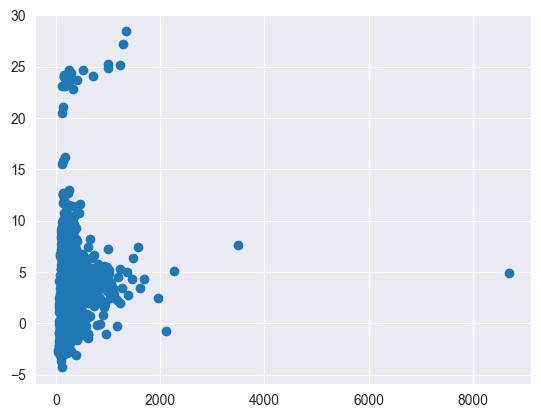

In [6]:
# Visual Check
# Define dependent and independent variables
X_cols = listings_df.columns.to_list()[:-1]
X = listings_df[X_cols].drop(['room_type_Hotel room', 'room_type_Shared room'], axis=1)
y = listings_df['legal_listing']

# Add constant
X = sm.add_constant(X, prepend=False)

# Re-run logistic regression on original set of X and y variables
logit_results = GLM(y, X, family=families.Binomial()).fit()
predicted = logit_results.predict(X)

# Get log odds values
log_odds = np.log(predicted / (1 - predicted))

# Visualize predictor continuous variable vs logit values (Age)
plt.scatter(x = listings_df['price'].values, y = log_odds);
plt.show()
# Confirming that there is no logit linearity for the 'price' variable 

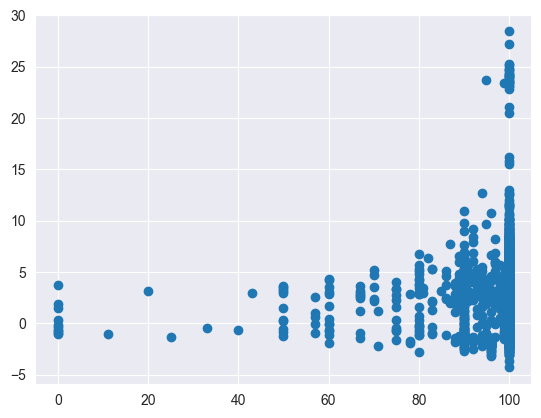

In [7]:
# Visualize predictor variable vs logit values for 'host_response_rate'
plt.scatter(x = listings_df['host_response_rate'].values, y = log_odds);
plt.show()

In [8]:
## Assumption 2 — No strongly influential outliers

# Use GLM method for logreg here so that we can retrieve the influence measures
logit_model = GLM(y, X, family=families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          legal_listing   No. Observations:                 3583
Model:                            GLM   Df Residuals:                     3540
Model Family:                Binomial   Df Model:                           42
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -928.63
Date:                Fri, 01 Dec 2023   Deviance:                       1857.3
Time:                        15:50:01   Pearson chi2:                 3.89e+04
No. Iterations:                    22   Pseudo R-squ. (CS):             0.4145
Covariance Type:            nonrobust                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [9]:
# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook distance
diagnosis_df = summ_df.loc[:,['cooks_d']]

# Append absolute standardized residual values
diagnosis_df['std_resid'] = stats.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df.loc[:,'std_resid'].apply(lambda x: np.abs(x))

# Sort by Cook's Distance
diagnosis_df.sort_values("cooks_d", ascending=False)
diagnosis_df.head()
     

,cooks_d,std_resid
0,1.448033e-11,0.029364
1,2.693768e-03,0.796688
2,7.840719e-06,0.081388
3,1.034099e-03,0.395302
4,6.064458e-06,0.077876


Threshold for Cook Distance = 0.0011163829193413341


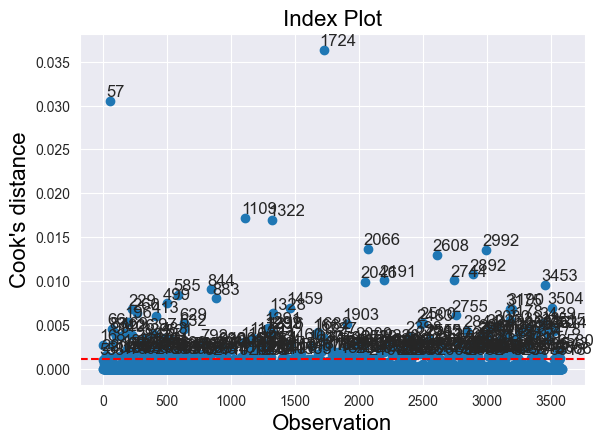

In [10]:
# Set Cook's distance threshold
cook_threshold = 4 / len(listings_df)
print(f"Threshold for Cook Distance = {cook_threshold}")

# Plot influence measures (Cook's distance)
fig = influence.plot_index(y_var="cooks", threshold=cook_threshold)
plt.axhline(y = cook_threshold, ls="--", color='red')
fig.tight_layout(pad=2)

In [11]:
# Find number of observations that exceed Cook's distance threshold
outliers = diagnosis_df[diagnosis_df['cooks_d'] > cook_threshold]
prop_outliers = round(100*(len(outliers) / len(listings_df)),1)
print(f'Proportion of data points that are highly influential = {prop_outliers}%')

Proportion of data points that are highly influential = 7.2%


In [12]:
# Find number of observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) & 
                       (diagnosis_df['std_resid'] > 3)]
prop_extreme = round(100*(len(extreme) / len(listings_df)),1)
# Display top most influential outliers
extreme.sort_values("cooks_d", ascending=False).head()

,cooks_d,std_resid
1724,0.036355,16.050794
57,0.030566,52.380381
844,0.009038,11.854802
499,0.007459,6.412854
1459,0.006941,3.977317


In [14]:
# Deep dive into index 24 and 62 (extreme outlier)
print(listings_df.iloc[57])

host_response_rate                                 100.00
number_of_reviews                                  559.00
availability_365                                   271.00
availability_30                                      0.00
has_availability                                     1.00
price                                              323.00
host_response_time                                   0.75
host_verifications                                   0.75
host_total_listings_count                            9.00
host_has_profile_pic                                 1.00
host_acceptance_rate                                98.00
number_of_reviews_l30d                               3.00
review_scores_checkin                                4.91
beds                                                 2.00
calculated_host_listings_count_private_rooms         1.00
instant_bookable                                     0.00
review_scores_cleanliness                            4.93
host_identity_